# Credit Risk Resampling Techniques

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import os
os.getcwd()

'C:\\Users\\otrin\\OneDrive\\Desktop\\Git\\machine_learning'

# Read the CSV and Perform Basic Data Cleaning

In [3]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [4]:
# Load the data
file_path = Path('Resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


# Split the Data into Training and Testing

In [5]:
# Create our features
X_df = df.drop(columns=['loan_status'])
X = pd.get_dummies(X_df, columns=["home_ownership","verification_status","issue_d",
                                  "pymnt_plan","initial_list_status","next_pymnt_d","debt_settlement_flag",
                                  "application_type","hardship_flag"], drop_first = True)

# Create our target
y = df['loan_status'].to_frame()
type(y)

pandas.core.frame.DataFrame

In [6]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,issue_d_Jan-2019,issue_d_Mar-2019,initial_list_status_w,next_pymnt_d_May-2019,application_type_Joint App
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.526309,0.106747,0.357659,0.373992,0.148001,0.451066,0.177238,0.876121,0.616839,0.139660
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.499311,0.308793,0.479314,0.483865,0.355104,0.497603,0.381873,0.329446,0.486161,0.346637
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
# Check the balance of our target values
y['loan_status'].value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [8]:
# Create X_train, X_test, y_train, y_test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [9]:
# Resample the training data with the RandomOversampler
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

y_resampled['loan_status'].value_counts()

high_risk    51352
low_risk     51352
Name: loan_status, dtype: int64

In [10]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [11]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.6500316263179311

In [12]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[   56,    31],
       [ 5882, 11236]], dtype=int64)

In [13]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.64      0.66      0.02      0.65      0.42        87
   low_risk       1.00      0.66      0.64      0.79      0.65      0.42     17118

avg / total       0.99      0.66      0.64      0.79      0.65      0.42     17205



### SMOTE Oversampling

In [14]:
# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy=1.0).fit_resample(
    X_train, y_train
)
from collections import Counter

Counter(y_resampled)

Counter({'loan_status': 1})

In [15]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [16]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.622025212420078

In [17]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[   47,    40],
       [ 5070, 12048]], dtype=int64)

In [18]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.54      0.70      0.02      0.62      0.37        87
   low_risk       1.00      0.70      0.54      0.83      0.62      0.39     17118

avg / total       0.99      0.70      0.54      0.82      0.62      0.39     17205



# Undersampling

In this section, you will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [19]:
# Resample the data using the ClusterCentroids resampler
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)

from collections import Counter

Counter(y_resampled)

Counter({'loan_status': 1})

In [20]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [21]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.5159320094596935

In [22]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[  52,   35],
       [9686, 7432]], dtype=int64)

In [23]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.60      0.43      0.01      0.51      0.26        87
   low_risk       1.00      0.43      0.60      0.60      0.51      0.26     17118

avg / total       0.99      0.43      0.60      0.60      0.51      0.26     17205



# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [24]:
# Resample the training data with SMOTEENN
from imblearn.combine import SMOTEENN

sm = SMOTEENN(random_state=1)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'loan_status': 1})

In [25]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [26]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.6081902091365814

In [27]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[  58,   29],
       [7708, 9410]], dtype=int64)

In [28]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.67      0.55      0.01      0.61      0.37        87
   low_risk       1.00      0.55      0.67      0.71      0.61      0.36     17118

avg / total       0.99      0.55      0.67      0.71      0.61      0.36     17205



Table 1: Naive Random Oversampling

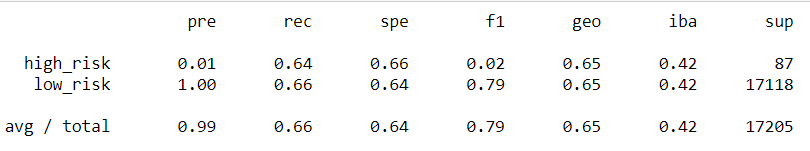

Table 2: SMOTE Oversampling

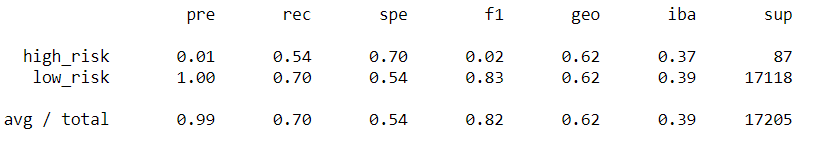

Table 3: Undersampling

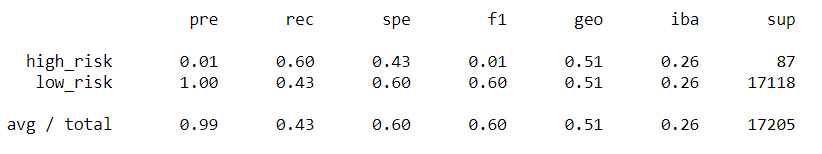

Table 4: Combination Over- Under-sampling

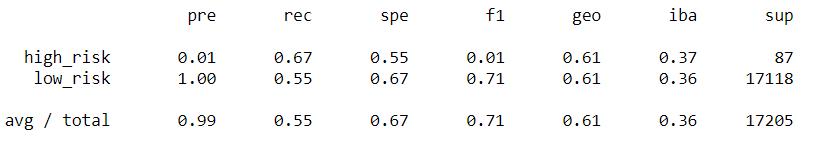

## Precision
    
All methods resulted in the same precision at 0.99

## Recall

Recall resulted in best scores for SMOTE Oversampling at 0.7, with Naive Oversampling at 0.66, Combination 0.55. Undersampling has the lowest score at 0.43.

## Balanced Accuracy

Naive Oversampling - 0.65

SMOTE Oversampling - 0.62

Undersampling - 0.52

Combination - o.61

## Recommendation
The scores above indicates balanced accuracy for Naive Oversampling as the highest among the methods used. It also resulted in the best recall scores. In this instance, Naive Oversampling should be used to best predict credit risk.